In [1]:
!pip install python_speech_features
!pip install scipy

  Preparing metadata (setup.py) ... - done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=f61500d14b9c37c15cc92af7d2b5ad013e0ff2cac3d1332a230780d1da8a39da
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python_speech_features


In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from python_speech_features import mfcc
from tempfile import TemporaryFile
import os
import math
import pickle
import random
import operator
import librosa
import librosa.display
import soundfile as sf
import random
import IPython.display as ipd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from xgboost import XGBClassifier

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [3]:
def get_random_song():
    path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'
    genres = os.listdir(path)
    
    selected_genre = random.choice(genres)
    
    songs = genres = os.listdir(path + "/" + selected_genre)
    
    selected_song = random.choice(songs)
    
    x, sr = sf.read(path + "/" + selected_genre + "/" + selected_song, always_2d=True)
    
    return (x, sr, selected_genre, path + "/" + selected_genre + "/" + selected_song)
    
    

In [4]:
x, sr, genre, path = get_random_song()
print(genre)
print(path)
ipd.Audio(path)

reggae
/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/reggae/reggae.00033.wav


In [5]:
model_tracker = pd.DataFrame(columns=['model','accuracy'])

In [6]:
def update_tracker(name, predictions, y_test):
    accuracy = accuracy_score(predictions, y_test)
    
    model_tracker.loc[model_tracker.shape[0]] = [name, accuracy]
    
    return model_tracker

In [7]:
def parse_audio(x):
    return x.flatten('F')[:x.shape[0]]

In [8]:
data_directory = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'

data = []
labels = []
bad_files = []

for folder in os.listdir(data_directory):
    for song in os.listdir(data_directory + "/" + folder):
        try:
            x, sr = sf.read(data_directory + "/" + folder + "/" + song, always_2d=True)
            #x = parse_audio(x)
            mfcc_feat = mfcc(x, sr, winlen = 0.020, appendEnergy=False)
            means = mfcc_feat.mean(0)
            data.append(means)
            labels.append(folder)
        except Exception:
            bad_files.append(song)
        

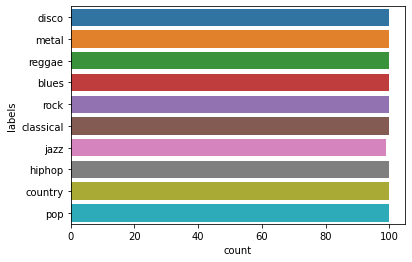

In [9]:
label_df = pd.DataFrame(labels, columns=['labels'])
ax = sns.countplot(y="labels", data=label_df)

There is no class imbalance in this dataset.

In [10]:
X = np.array(data)
Y = labels

In [11]:
le = LabelEncoder()
Y_encoded = le.fit_transform(Y)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_encoded)

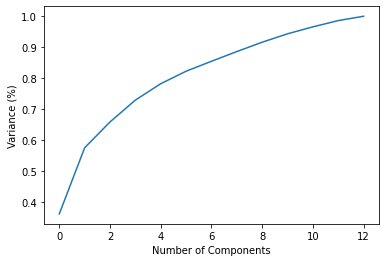

In [13]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA().fit(X_train_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.show()

In [14]:
model = XGBClassifier()
model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [15]:
y_predict = model.predict(X_test_scaled)
update_tracker('xgb', y_predict, y_test)

,model,accuracy
0,xgb,0.56


In [16]:
grid_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

model = GridSearchCV(KNeighborsClassifier(), grid_params, cv=5, n_jobs=-1)
model.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11, 15],
                         'weights': ['uniform', 'distance']})

In [17]:
y_predict = model.predict(X_test_scaled)
update_tracker('knn', y_predict, y_test)

,model,accuracy
0,xgb,0.56
1,knn,0.62


In [18]:
X_train_reshaped = X_train.reshape(-1, 1, 13)

In [19]:
X_test_reshaped = X_test.reshape(-1, 1, 13)

In [20]:
input_shape=X_train_reshaped[0].shape

model = Sequential()
model.add(LSTM(128,input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(48, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(24, activation='softmax'))

model.compile(optimizer='adam',loss='SparseCategoricalCrossentropy',metrics=['acc'])

history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=72, 
                    validation_data=(X_test_reshaped, y_test), shuffle=False)


2022-06-01 01:40:28.459376: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-06-01 01:40:28.997385: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
11/11 [==============================] - 4s 95ms/step - loss: 3.0546 - acc: 0.0935 - val_loss: 2.8717 - val_acc: 0.2000
Epoch 2/50
11/11 [==============================] - 0s 43ms/step - loss: 2.7746 - acc: 0.1642 - val_loss: 2.5226 - val_acc: 0.2160
Epoch 3/50
11/11 [==============================] - 0s 18ms/step - loss: 2.4845 - acc: 0.1936 - val_loss: 2.1755 - val_acc: 0.2880
Epoch 4/50
11/11 [==============================] - 0s 12ms/step - loss: 2.2552 - acc: 0.2310 - val_loss: 1.9501 - val_acc: 0.4000
Epoch 5/50
11/11 [==============================] - 0s 22ms/step - loss: 2.0405 - acc: 0.3031 - val_loss: 1.8163 - val_acc: 0.4200
Epoch 6/50
11/11 [==============================] - 0s 12ms/step - loss: 1.9901 - acc: 0.3151 - val_loss: 1.7258 - val_acc: 0.4480
Epoch 7/50
11/11 [==============================] - 0s 11ms/step - loss: 1.8908 - acc: 0.3311 - val_loss: 1.6822 - val_acc: 0.4680
Epoch 8/50
11/11 [==============================] - 0s 13ms/step - loss: 1.7970 - a

In [21]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

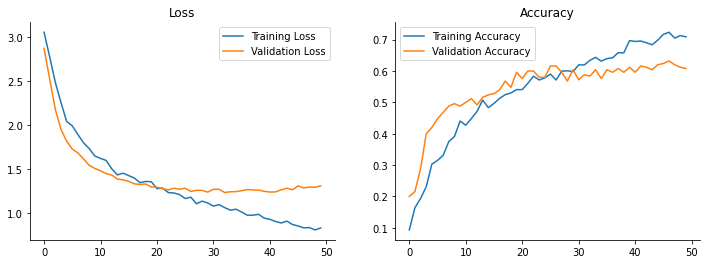

In [22]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.lineplot(x = range(len(history.history["loss"])), y = history.history["loss"], ax = axes[0], label = "Training Loss")
sns.lineplot(x = range(len(history.history["loss"])), y = history.history["val_loss"], ax = axes[0], label = "Validation Loss")

sns.lineplot(x = range(len(history.history["acc"])), y = history.history["acc"], ax = axes[1], label = "Training Accuracy")
sns.lineplot(x = range(len(history.history["acc"])), y = history.history["val_acc"], ax = axes[1], label = "Validation Accuracy")
axes[0].set_title("Loss"); axes[1].set_title("Accuracy")

sns.despine()
plt.show()